1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..13.504393386840821].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..13.576470601558686].


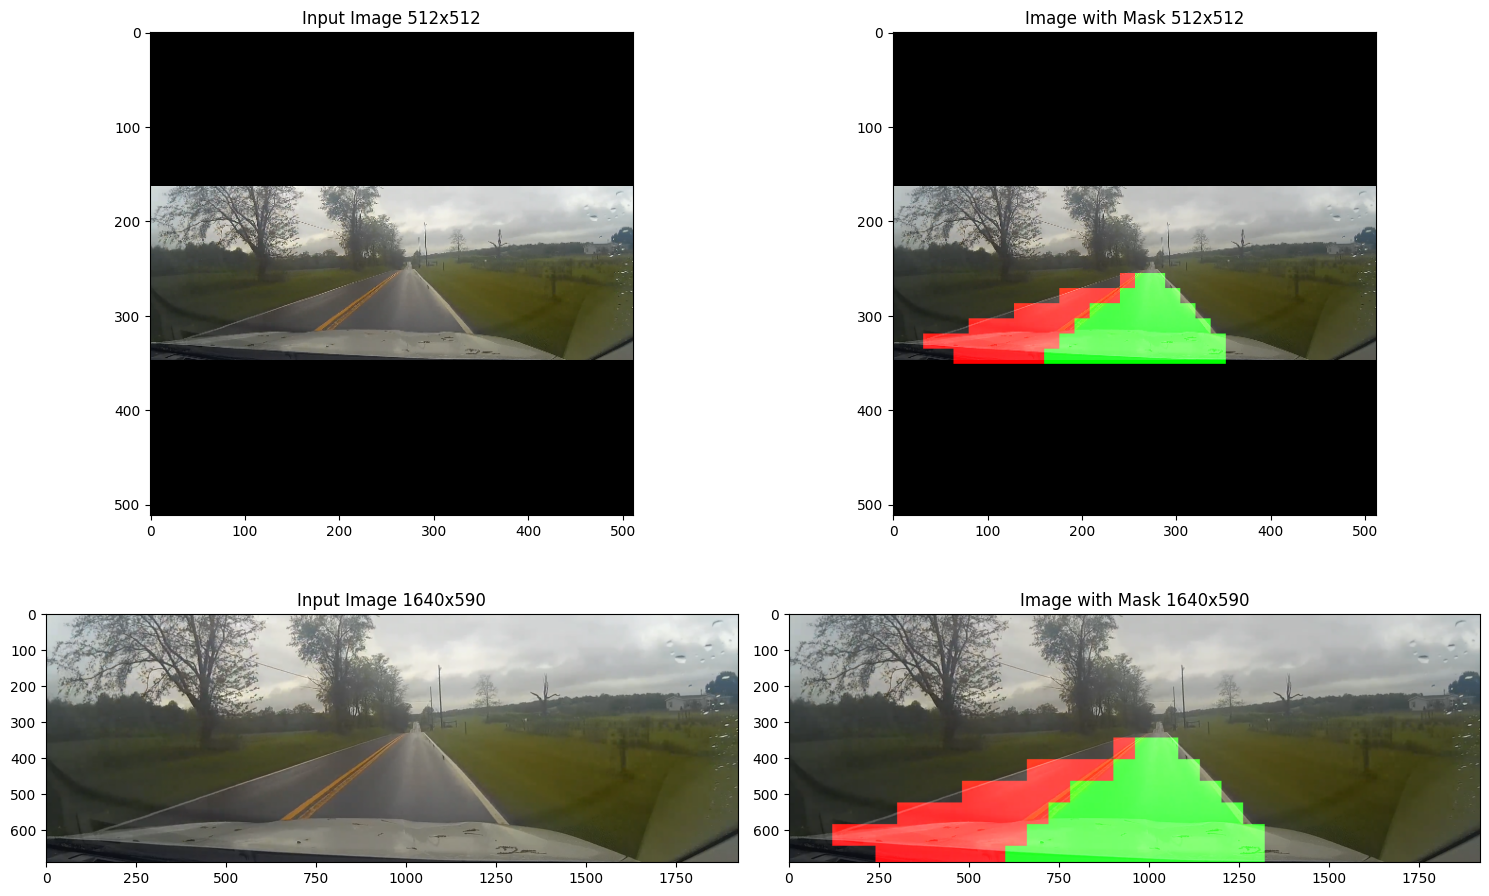

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import get_custom_objects, register_keras_serializable

@register_keras_serializable()
class Cast(tf.keras.layers.Layer):
    def __init__(self, dtype='float32', **kwargs):
        super(Cast, self).__init__(**kwargs)
        self._dtype = dtype

    def call(self, inputs):
        return tf.cast(inputs, self._dtype)

@register_keras_serializable()
class ASPP(tf.keras.layers.Layer):
    def __init__(self, filters, dilation_rates, **kwargs):
        super(ASPP, self).__init__(**kwargs)
        self.conv_layers = []
        for rate in dilation_rates:
            self.conv_layers.append(
                tf.keras.Sequential([ 
                    tf.keras.layers.Conv2D(filters, 3, padding="same", dilation_rate=rate, use_bias=False),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU()
                ])
            )
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.conv1x1 = tf.keras.layers.Conv2D(filters, 1, activation='relu')

    def call(self, inputs):
        outputs = [conv(inputs) for conv in self.conv_layers]
        avg_pooled = self.global_avg_pool(inputs)
        avg_pooled = tf.expand_dims(tf.expand_dims(avg_pooled, 1), 1)
        avg_pooled = self.conv1x1(avg_pooled)
        avg_pooled = tf.keras.layers.UpSampling2D(size=(inputs.shape[1], inputs.shape[2]))(avg_pooled)
        return tf.concat(outputs + [avg_pooled], axis=-1)

def padding_extended(image, target_size):    
    original_width, original_height = image.size
    target_height, target_width = target_size, target_size

    if original_height > original_width:
        new_height = target_height
        new_width = int(original_width * (target_height / original_height))
    else:
        new_width = target_width
        new_height = int(original_height * (target_width / original_width))
    
    padding_top = (target_height - new_height) // 2
    padding_bottom = target_height - new_height - padding_top
    padding_left = (target_width - new_width) // 2
    padding_right = target_width - new_width - padding_left

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    resized_image = tf.image.resize(image, (new_height, new_width))

    padded_image = tf.pad(
        resized_image,
        paddings=[[padding_top, padding_bottom], [padding_left, padding_right], [0, 0]],
        mode='CONSTANT',
        constant_values=0.0
    )

    padding_info = {
        'top': padding_top,
        'bottom': padding_bottom,
        'left': padding_left,
        'right': padding_right
    }

    return padded_image, padding_info

get_custom_objects().update({'ASPP': ASPP, 'Cast': Cast})

def crop_to_aspect_ratio(img: np.ndarray, aspect_ratio: float) -> np.ndarray:
    h, w = img.shape[:2]
    current_ratio = w / h

    if current_ratio > aspect_ratio:
        new_width = int(h * aspect_ratio)
        start_x = (w - new_width) // 2
        cropped = img[:, start_x:start_x + new_width]
    else:
        new_height = int(w / aspect_ratio)
        start_y = (h - new_height) // 2
        cropped = img[start_y:start_y + new_height, :]

    return cropped

height, width = 512, 512
aspect_ratio = 1640 / 590

model = load_model('deeplabv3.keras', compile=False)

img_path = r'..\screenshots\inference_example_input_1.png'

img = image.load_img(img_path)

img_raw_np = np.array(img)

img_cropped_np = crop_to_aspect_ratio(img_raw_np, aspect_ratio)

orig_height, orig_width = img_cropped_np.shape[:2]

img = image.array_to_img(img_cropped_np)

img_orig_raw = img.copy()

resize_value = 512
resized_image, padding_info = padding_extended(img, resize_value)

img_orig = np.expand_dims(img_orig_raw, axis=0)
img_array = np.expand_dims(resized_image, axis=0)

prediction = model.predict(img_array)

predicted_mask = np.argmax(prediction, axis=-1)[0]

top = padding_info['top']
bottom = predicted_mask.shape[0] - padding_info['bottom']
left = padding_info['left']
right = predicted_mask.shape[1] - padding_info['right']

mask_cropped = predicted_mask[top:bottom, left:right]

colors = np.array([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], 
                   [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
                   [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
                   [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                   [0, 64, 128]])

color_mask = colors[predicted_mask]

color_mask_orig = cv2.resize(color_mask, (orig_width, orig_height), interpolation=cv2.INTER_NEAREST)

alpha = 0.1
overlay = img_array[0] * (1 - alpha) + color_mask * alpha

color_mask = colors[mask_cropped]
color_mask_orig = cv2.resize(color_mask, (orig_width, orig_height), interpolation=cv2.INTER_NEAREST)

img_orig_rescaled = np.asarray(img_orig_raw).astype(np.float32) / 255.0

overlay_orig = img_orig_rescaled * (1 - alpha) + color_mask_orig * alpha

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.title('Input Image 512x512')
plt.imshow(tf.image.resize(img_array[0], (height, width)))

plt.subplot(2, 2, 2)
plt.title('Image with Mask 512x512')
plt.imshow(overlay)

plt.subplot(2, 2, 3)
plt.title('Input Image 1640x590')
plt.imshow(img_orig_raw)

plt.subplot(2, 2, 4)
plt.title('Image with Mask 1640x590')
plt.imshow(overlay_orig)

plt.tight_layout()
plt.show()